We're going to learn more about working with missing data and new tips dealing with it, including:

* How to handle missing data without having to drop rows and columns using the **imputation**.
* How to visualize missing data and missing data correlations matrix with **heatmaps**.
* How to analyze missing data using visualization.

The dataset we'll use is on motor vehicle collisions released by New York City (NYC) and published on the [NYC OpenData website](https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95). There is data on over 1.5 million collisions dating back to 2012, with additional data continuously added.

Our dataset is in a CSV called `nypd_mvc_2018.csv`. We can load the dataset in R and inspect the first few rows of the data:

`library(readr)
mvc  <-  read_csv("nypd_mvc_2018.csv")
head(mvc, 4)`

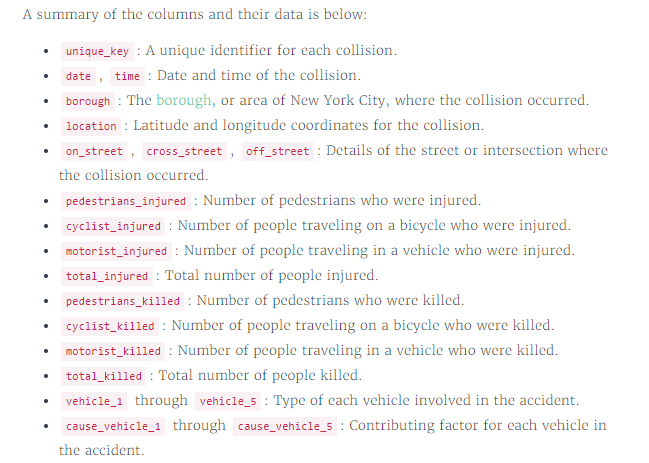

Let's quickly recap how to check missing values. We'll start by creating a dataframe with some NA values, which represent missing values:

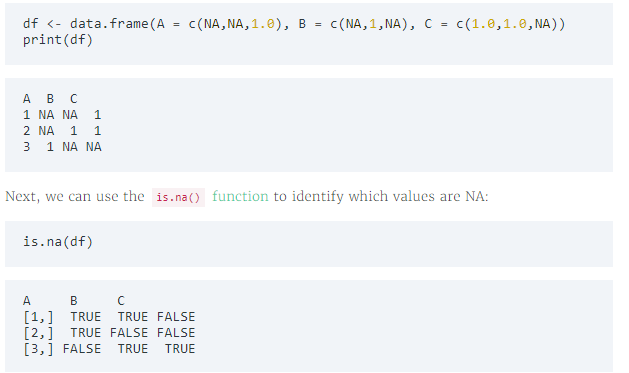

**Task**

* Create a vector that counts the number of NA values in each of the columns in the `mvc` dataframe. Assign the result to `na_logical`.

**Answer**

`na_logical  <-  is.na(mvc)`

We can sum the output of the `is.na()` function using the built-in [R function colSums()](https://stat.ethz.ch/R-manual/R-devel/library/base/html/colSums.html), to count the number of NA values in each column.

There is also the complement to this function which allows us to sum up the rows, [rowSums() function](https://stat.ethz.ch/R-manual/R-devel/library/base/html/colSums.html)].

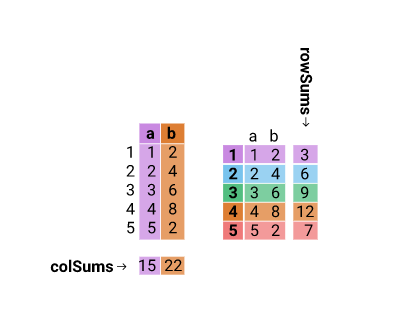

**Task**

* Create a dataframe, `mvc_na`, containing logical values which indicate where missing values are.
* Create a new column, `total_na_injured`, by summing the variables `pedestrians_injured`, `cyclist_injured`, `motorist_injured` from `mvc_na` dataframe.


**Answer**

`library(dplyr)`

`mvc_na <- data.frame(is.na(mvc))`

`mvc_na_injured <- mvc_na %>%
    mutate(total_na_injured = rowSums(.[9:11]))`
    
In the above code, we use period (`.`) to represent all the dataset, and then we take its subset.

To give us a better picture of the NA values in the data, let's calculate the percentage of NA values in each column. Below, we divide the number of NA values in each column by the total number of values in this column.

`library(dplyr)
na_counts  <-  mvc %>% is.na() %>% colSums()
na_counts_pct  <-  na_counts * 100 / nrow(mvc)`

We'll then add both the counts and percentages to a dataframe to make them easier to compare.

`na_df <- data.frame(na_counts = na_counts, na_pct = na_counts_pct )`
`# Rotate the dataframe so that rows become columns and vice-versa`
`na_df  <-  data.frame(t(na_df))
print(na_df)`

It is worth noting that for the convenience of reading, we have rotated the dataframe. To do this, we combine the transposed [function `t()`](https://stat.ethz.ch/R-manual/R-devel/library/base/html/t.html) which always outputs a matrix and the [`data.frame()` function](https://stat.ethz.ch/R-manual/R-devel/library/base/html/data.frame.html) to convert this matrix into a dataframe.

About a third of the columns have no NA values, with the rest ranging from less than 1% to 99%!

To make things easier, let's start by looking at the group of columns that relate to people killed in collisions.

We'll use the combination of `select()` with `ends_with()` functions from `dplyr` package, to reduce our summary dataframe to just those columns. The `ends_with()` function works only with `select()` function and allows selecting column names which end with a given string. In our dataset, the group of columns that relate to people killed in collisions ends with `"_killed"`.

`library(dplyr)`

`na_df_killed <- na_df %>% 
    select(ends_with("_killed"))`

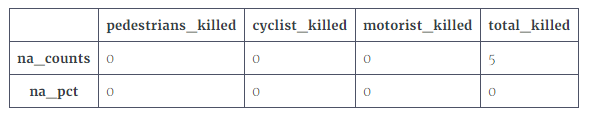

We can see that each of the individual categories have no missing values, but the `total_killed` column has five missing values.

One option for handling this would be to remove – or drop – those five rows. This would be a reasonably valid choice since it's a tiny portion of the data, but let's think about what other options we have first.

If we think about it, the total number of people killed should be the sum of each of the individual categories. We might be able to "fill in" the missing values with the sums of the individual columns for that row. The technical name for filling in a missing value with a replacement value is called **imputation**.

Let's look at how we could explore the values where the `total_killed` isn't equal to the sum of the other three columns.

**Task**

* Create a dataframe, killed, containing the four columns that relate to people killed in collisions.

1. Select the first three columns from killed and sum each row.

    * Assign the result to a new column `manual_sum` using the `mutate()` function.

2. Filter the `killed` rows where each value in the `manual_sum` column either **is not** equal to the values in the `total_killed` column or the `total_killed` column is `NA` value.

3. Assign the resulting dataframe to `killed_non_eq`.

**Answer**

`killed  <-  mvc %>% select(ends_with("_killed"))
killed_non_eq <- killed %>% 
    mutate(manual_sum = rowSums(.[1:3])) %>%
    filter(manual_sum != total_killed | is.na(total_killed))`

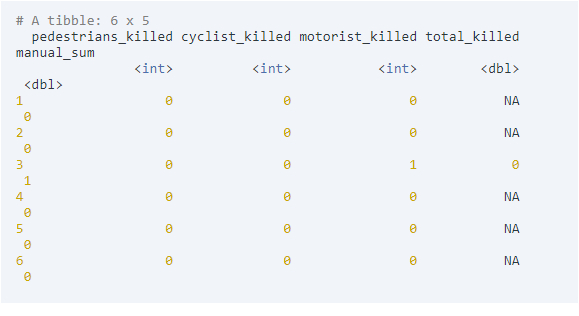

We can categorize these into two categories:

1. Five rows where the `total_killed` is not equal to the sum of the other columns because the total value is missing.
2. One row where the `total_killed` is less than the sum of the other columns.

From this, we can conclude that filling NA values with the sum of the columns is a fairly good choice for our imputation, given that only six rows out of around 58,000 don't match this pattern.

We've also identified a row that has suspicious data - one that doesn't sum correctly. Once we have imputed values for all rows with missing values for `total_killed`, we'll mark this suspect row by setting its value to `NA`.

In order to execute this, we'll learn to use the combination of the well-known `mutate()` function and `if_else()` function from the dplyr package. This combination is useful when we want to replace certain values in a vector based on a logical vector. The syntax for the function is:

`df %>% mutate(colname = if_else(condition, val_if_true, val_if_false))`

Above, we can also update with the matching value from a vector that has identical index labels

Let's look at how we'd use this technique to update the values in the `total_killed` column. First, we'll replace all NA values with the equivalent values from our `manual_sum` variable:

`killed_non_eq <- killed_non_eq %>%
    mutate(total_killed = if_else(
        is.na(total_killed), 
        manual_sum, 
        total_killed 
      )
    )`

Next, we'll replace any values where the manual sum and the total column aren't equal with NaN.

`killed_non_eq <- killed_non_eq %>%
    mutate(total_killed = if_else(
        total_killed != manual_sum, 
        NaN, 
        total_killed 
      )
    )`

**Task**

* Let's do the same for the injured columns.

**Answer**

`# Create an injured_non_eq dataframe and manually sum values`

`injured  <-  mvc %>% select(ends_with("_injured"))`

`injured_non_eq <- injured %>% 
    mutate(manual_sum = rowSums(.[1:3])) %>%
    filter(manual_sum != total_injured | is.na(total_injured))`
    
`injured_non_eq <- injured_non_eq %>%
    mutate(total_injured = if_else(is.na(total_injured), manual_sum, total_injured ))`


`injured_non_eq <- injured_non_eq %>%
    mutate(total_injured = if_else(total_injured != manual_sum, NaN, total_injured ))`

Earlier, we used a table of numbers to understand the number of missing values in our dataframe. A different approach we can take is to use a plot to visualize the missing values.

First of all, we have to prepare our data. Since, we want to work with missing data, let's transform our dataset, `mvc`, into a dataframe where values are `1` if they are NA values and `0` otherwise. To do this, we will combine [`is.na()` function](https://stat.ethz.ch/R-manual/R-devel/library/base/html/NA.html) and [`as.numeric()` function](https://stat.ethz.ch/R-manual/R-devel/library/base/html/numeric.html) applied to each column using [`map_df()` function](https://purrr.tidyverse.org/reference/map.html) and an anonymous function.

`library(purrr)
mvc_na <- map_df(mvc, function(x) as.numeric(is.na(x)))`

One of the most suitable visualizations for missing data is heatmaps. The data, as they currently stand, are not compatible with this. We would need to have data with three variables `x`, `y`, and `value` where :

* `x` represents the x-axis and contains the column name from our current dataset.
* `y` represents the x-axis and contains the row number from our current dataset.
* `value` represents values from our current dataset flattened as one column.

In R, we can obtain this result by using the [`pivot_longer()` function](https://tidyr.tidyverse.org/reference/pivot_longer.html) to transform the dataframe into key-value pairs dataframe and then adding row numbers using the [`row_number()` function](https://dplyr.tidyverse.org/reference/ranking.html). 

`library(dplyr)
library(tidyr)`

`df_heat <- df %>%
  pivot_longer(cols = everything(),
               names_to = "x") %>%
  group_by(x) %>%
  mutate(y = row_number())`

`print(df_heat)`

Notice the use of the [`group_by()` function](https://dplyr.tidyverse.org/reference/group_by.html) to number rows by column. We also use the [function `everything()`](https://tidyselect.r-lib.org/reference/select_helpers.html) to indicate that all columns are involved in the reshaping process. The function `everything()` is a "helper function" for selecting variables that is to be included as the argument to the `cols` parameter. Using this function is equivalent to listing the names of all variables in the dataframe to the `cols` parameter.

**Task**

* Let's use the same technique to prepare our dataset.

**Answer**

`library(purrr)`

`mvc_na <- map_df(mvc, function(x) as.numeric(is.na(x)))
library(tidyr)`
                 
`mvc_na_heat <- mvc_na %>%
    pivot_longer(cols = everything(),
               names_to = "x") %>%
    group_by(x) %>%
    mutate(y = row_number())`

`head(mvc_na_heat, 10)`

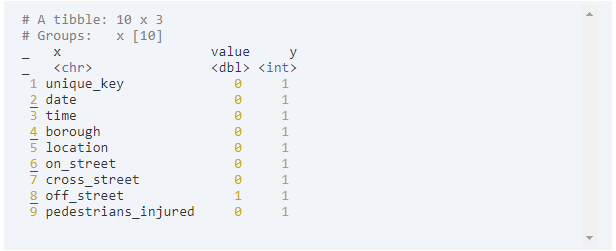

Let's create a helper function to create heatmaps. The function below uses `geom_tile()` function from `ggplot2` package to represent NA values as light squares and non-NA values as dark squares

plot_na_matrix <- function(df) {

    # Preparing the dataframe for heatmaps 
    df_heat <- df %>%
        pivot_longer(cols = everything(),
               names_to = "x") %>%
        group_by(x) %>%
        mutate(y = row_number())

    # Ensuring the order of columns is kept as it is
    df_heat <- df_heat %>%
        ungroup() %>%
        mutate(x = factor(x,levels = colnames(df)))

    # Plotting data
    g <- ggplot(data = df_heat, aes(x=x, y=y, fill=value)) + 
        geom_tile() + 
        theme(legend.position = "none",
              axis.title.y=element_blank(),
              axis.text.y =element_blank(),
              axis.ticks.y=element_blank(),
              axis.title.x=element_blank(),
              axis.text.x = element_text(angle = 90, hjust = 1))

    # Returning the plot
    g
}

Let's look at how the function works by using it to plot just the first row of our mvc dataframe. We'll display the first row as a table immediately below so it's easy to compare:

`plot_na_matrix(mvc_na[1, ])`

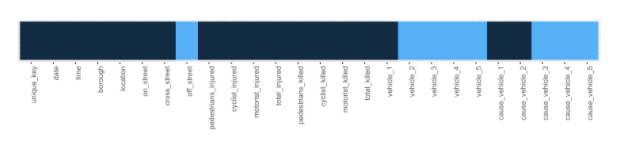

Each value is represented by a dark square, and each missing value is represented by a light square.

Let's look at what a plot matrix looks like for the whole dataframe:

`plot_na_matrix(mvc_na)`

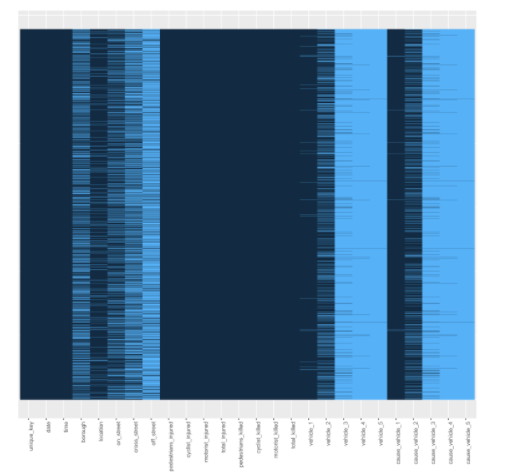

We can make some immediate interpretations about our dataframe:

* The first three columns have few to no missing values.
* The next five columns have missing values scattered throughout, with each column seeming to have its own density of missing values.
* The next eight columns are the `injury` and `killed` columns we just learned how to clean.
* The last 10 columns seem to break into two groups of five, with each group of five having similar patterns of NA/non-NA values.

**Task**

* Let's visualize the missing data in the dataframe of vehicle variables.

**Answer**

`library(ggplot2)`

`mvc_na_vehicle <- mvc_na %>% select(contains("vehicle"))
plot_na_matrix(mvc_na_vehicle)`

We realized that the last 10 columns seem to break into two groups of five, with each group of five having similar patterns of NA/non-NA values.

Let's examine the pattern in these last 10 columns a little more closely. We can calculate the relationship between two sets of columns, known as **correlation**. To calculate this, we use the `cor()` function

`cols_with_missing_vals  <-  colnames(mvc)[colSums(mvc_na)> 0]
missing_corr  <-  round(cor(mvc_na[cols_with_missing_vals]),6)
head(missing_corr)`

Each value is between −1 and 1, and represents the relationship between two columns. A number close to −1 or 1 represents a strong relationship, whereas a number in the middle (close to 0) represents a weak relationship.

If we look closely, we can see a diagonal line of 1s going from top left to bottom right. These values represent each column's relationship with itself, which of course is a perfect relationship. The values on the top/right of this "line of 1s" mirror the values on the bottom/left of this line: The table actually repeats every value twice!

Correlation tables can be hard to interpret. We can convert our table into a heatmap, which will make this a lot easier.

We provide with this helper for this visualization:

plot_na_correlation <- function(df) {
    # Taking the lower triangle of the correlation matrix
    missing_corr_up <- df
    missing_corr_up[lower.tri(missing_corr_up)] <- NA
    missing_corr_up <- data.frame(missing_corr_up)
    
    # Preparing the dataframe for heatmaps 
    col_names <- colnames(missing_corr_up)
    
    missing_corr_up_heat <- missing_corr_up %>%
        pivot_longer(cols = everything(),
               names_to = "x") %>%
        group_by(x) %>%
        mutate(y = col_names[row_number()])  %>%
        na.omit
    
    # Ordering triangle
    ordered_cols_asc <- col_names[order(colSums(is.na(missing_corr_up)))]
    ordered_cols_desc <- col_names[order(-colSums(is.na(missing_corr_up)))]
    
    missing_corr_up_heat <- missing_corr_up_heat %>%
        ungroup() %>%
        mutate(x = factor(x,levels = ordered_cols_asc)) %>%
        mutate(y = factor(y,levels = ordered_cols_desc))
    
    # Plotting heatmaps
    g <- ggplot(data = missing_corr_up_heat, aes(x=x, y=y, fill=value)) + 
        geom_tile() + 
        geom_text(aes(label=value)) +
        theme_minimal() +
        scale_fill_gradientn(colours = c("white", "yellow", "red"), values = c(-1,0,1)) +
        theme(legend.position = "none",
              axis.title.y=element_blank(),
              axis.title.x=element_blank(),
              axis.text.x = element_text(angle = 90, hjust = 1))
    
    # Returning the plot
    g
}

The code to plot these correlations looks like this:
    
`#plot using plot_na_correlation
plot_na_correlation(missing_corr)`

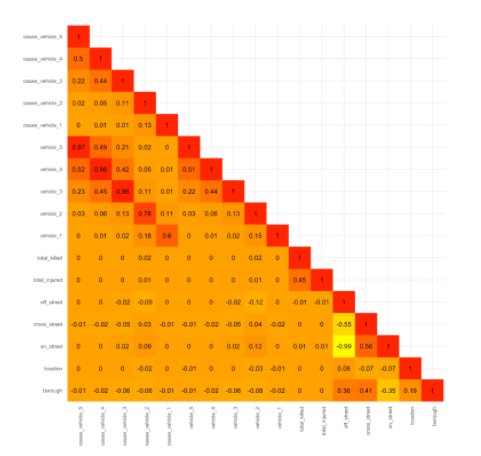

In our correlation plot:

* Values very close to 0, where there is little to no relationship, are in orange color.

* Values close to 1 are red and values close to −1 are yellow — the depth of color represents the strength of the relationship.

**Task**

* Let's create a correlation plot of just those last 10 columns to see if we can more closely identify the pattern we saw earlier in the matrix plot.

**Answer**

`mvc_na_vehicle <- mvc_na %>% select(contains("vehicle"))
missing_vehicle_corr  <-  round(cor(mvc_na_vehicle), 2)
plot_na_correlation(missing_vehicle_corr)`

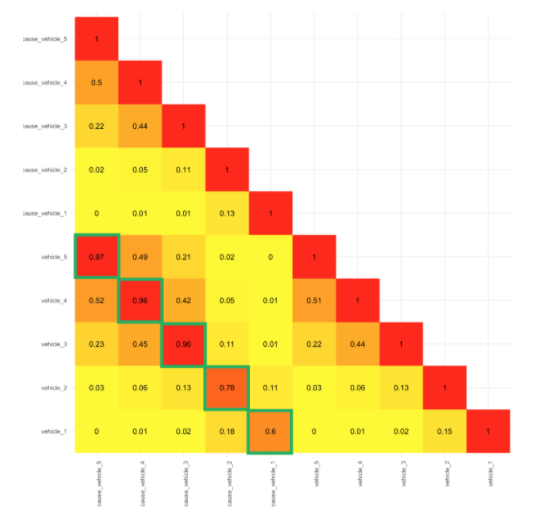

We outlined a diagonal strip of five squares in green that have a higher correlation than the rest. The pairs of column names that make up these five correlations are:

* vehicle_1 and cause_vehicle_1
* vehicle_2 and cause_vehicle_2
* vehicle_3 and cause_vehicle_3
* vehicle_4 and cause_vehicle_4
* vehicle_5 and cause_vehicle_5

If we think about it, this makes sense. When a vehicle is in an accident, there is likely to be a cause, and vice-versa.

Let's explore the variations in missing values from these five pairs of columns. We'll create a dataframe that counts, for each pair:

* The number of values where the vehicle is missing when the cause is not missing.
* The number of values where the cause is missing when the vehicle is not missing.

`library(purrr)`

`col_labels  <-  c('v_number', 'vehicle_missing', 'cause_missing')`

`v_fun <- function(x){ 
    v_col <- paste('vehicle', x,  sep = "_" )
    c_col <- paste('cause_vehicle', x,  sep = "_" )
    sum(is.na(mvc[v_col]) & !is.na(mvc[c_col]))
}`

We have provided: A function `v_fun()` to count the number of rows where the column `vehicle_x` is NA and the column `cause_vehicle_x` is not NA (`x` is the number of vehicle and cause vehicle).

`v_na <- map_int(1:5, v_fun )`

A variable `v_na` containing the number of vehicle missing using `map_int()` and `v_fun()` functions.

**Task**

* Do the same for `cause`

**Answer**

`c_fun <- function(x){ 
    v_col <- paste('vehicle', x,  sep = "_" )
    c_col <- paste('cause_vehicle', x,  sep = "_" )
    sum(!is.na(mvc[v_col]) & is.na(mvc[c_col]))
}`

`c_na <- map_int(1:5, c_fun )`

**Task**
* Create a tibble `vc_na_df` containing, in order: `v`, `v_na`, and `c_na`.
    - Set the tibble column names to the provided vector, `col_labels`.

**Answer**

`vc_na_df  <-  tibble(1:5, v_na, c_na)
colnames(vc_na_df) <- col_labels`

The analysis we did indicates that there are roughly 4,500 missing values across the 10 columns. The easiest option for handling these would be to drop the rows with missing values. This would mean losing almost 10% of the total data, which is something we ideally want to avoid.

A better option is to impute the data, like we did earlier. Because the data in these columns is text data, we can't perform a numeric calculation to impute missing data like we did with the injuries and killed columns.

One common option when imputing is to use the most common value to fill in data. Let's look at the common values across these columns and see if we can use that to make a decision.

We've previously used the [table() function](https://stat.ethz.ch/R-manual/R-devel/library/base/html/table.html) to find the most common values in a single column. In this case, we want to find the most common values across multiple columns. In order to do this, we first need to convert our dataframe of multiple columns into one single column, and then we can use `table()` to count the items.

To convert a dataframe to a single column of values, we use the [`pivot_longer()` function](https://tidyr.tidyverse.org/reference/pivot_longer.html), which stacks a dataframe column into a key-value pairs dataframe object.

Let's combine the `pivot_longer()` and `table()` functions to count the most common values for the cause set of columns. We'll start by selecting only the columns containing the substring `cause`. The `starts_with()` function is similar to the `ends_with()` function that we have used recently.

`cause  <-  mvc %>% select(starts_with("cause_"))`

Next, we'll stack the values into a dataframe containing name and value variables:

`cause_1d <- cause %>% pivot_longer(cols = everything())
head(cause_1d)`

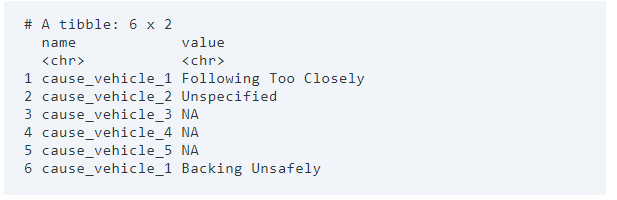

Finally, we count the values in the vectors and output the most common non-NA values.

`cause_counts  <-  table(cause_1d$value)
top5_causes  <-  head(sort(cause_counts, decreasing = T), 5)
print(top5_causes)`

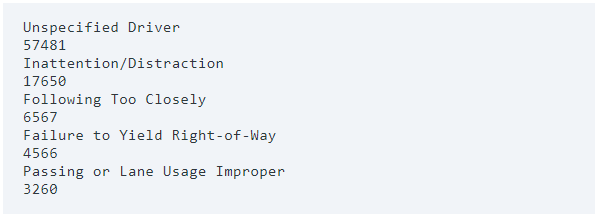

The most common non-NA value for the cause columns is `Unspecified`, which presumably indicates that the officer reporting the collision was unable to determine the cause for that vehicle.

**Task**

* Let's use the same technique to identify the most common non-NA value for the vehicle columns.

**Answer**

`vehicles  <-  mvc %>% select(starts_with("vehicle_"))
head(vehicles)`

`library(tidyr)
vehicles_1d  <-  vehicles %>% pivot_longer(cols = everything())
vehicles_counts  <-  table(vehicles_1d$value)
top10_vehicles  <-  head(sort(vehicles_counts, decreasing = T), 10)`

The top "cause" is an `"Unspecified"` placeholder. This is useful instead of a NA value as it makes the distinction between a value that is missing because there were only a certain number of vehicles in the collision versus one that is because the contributing cause for a particular vehicle is unknown.

The vehicles columns don't have an equivalent, but we can still use the same technique. Here's the logic we'll need to do for each pair of vehicle/cause columns:

1. For values where the vehicle is NA and the cause is non-NA, set the vehicle to `Unspecified`.
2. For values where the cause is NA and the vehicle is not-NA, set the cause to `Unspecified`.

We can use the functions `mutate()` and `if_else()` to replace the values.

Let's look at code to perform this for the `vehicle_1` and `vehicle_cause_1` columns:


### create a logical vector for each column

`v_missing_logical  <-  is.na(mvc['vehicle_1']) & !is.na(mvc['cause_vehicle_1'])
c_missing_logical  <-  !is.na(mvc['vehicle_1']) & is.na(mvc['cause_vehicle_1'])`


### replace the values matching the logical vector for each column

`mvc <- mvc %>%
    mutate(vehicle_1 = if_else(v_missing_logical,"Unspecified", vehicle_1 ))`

`mvc <- mvc %>%
    mutate(cause_vehicle_1 = if_else(c_missing_logical,"Unspecified", cause_vehicle_1 ))`

**Task**

* Now let's use a loop to fill in these values across all columns.

**Answer**

`v_fun <- function(x){ 
    v_col <- paste('vehicle', x,  sep = "_" )
    c_col <- paste('cause_vehicle', x,  sep = "_" )
    sum(is.na(mvc[v_col]) & !is.na(mvc[c_col]))
}`

`c_fun <- function(x){ 
    v_col <- paste('vehicle', x,  sep = "_" )
    c_col <- paste('cause_vehicle', x,  sep = "_" )
    sum(!is.na(mvc[v_col]) & is.na(mvc[c_col]))
}`

`summarize_missing <- function(){
    library(purrr)
    col_labels  <-  c('v_number', 'vehicle_missing', 'cause_missing')
    v_na <- map_int(1:5, v_fun )
    c_na <- map_int(1:5, c_fun )
    vc_na_df  <-  tibble(1:5, v_na, c_na)
    colnames(vc_na_df) <- col_labels
    vc_na_df
}`

`summary_before  <-  summarize_missing() `

`for (x in 1:5 ){`

    v_col <- paste('vehicle', x,  sep = "_" )
    c_col <- paste('cause_vehicle', x,  sep = "_" )
    
    # create a logical vector for each column
    v_missing_logical  <-  is.na(mvc[v_col]) & !is.na(mvc[c_col])
    c_missing_logical  <-  !is.na(mvc[v_col]) & is.na(mvc[c_col])`
    
    # replace the values matching the logical vector for each column
     mvc <- mvc %>%mutate_at(c(v_col), function(x) if_else(v_missing_logical,"Unspecified", v_col ))
    mvc <- mvc %>%mutate_at(c(c_col), function(x) if_else(c_missing_logical,"Unspecified", c_col ))}

`summary_after  <-  summarize_missing()`

`mvc_na_vehicle <- mvc_na %>% select(contains("vehicle"))
missing_vehicle_corr  <-  round(cor(mvc_na_vehicle), 2)
plot_na_correlation(missing_vehicle_corr)`

We can see the perfect correlation between each pair of vehicle/cause columns represented by 1.0 in each square, which means that there is a perfect relationship between the five pairs of vehicle/cause columns.

Let's now turn our focus to the final set of columns that contain missing values — the columns that relate to the location of the accident. We'll start by looking at the first few rows to refamiliarize ourselves with the data:

`location_cols  <-  c('borough', 'location', 'on_street', 'off_street', 'cross_street')
location_data  <-  mvc[location_cols]
head(location_data)`

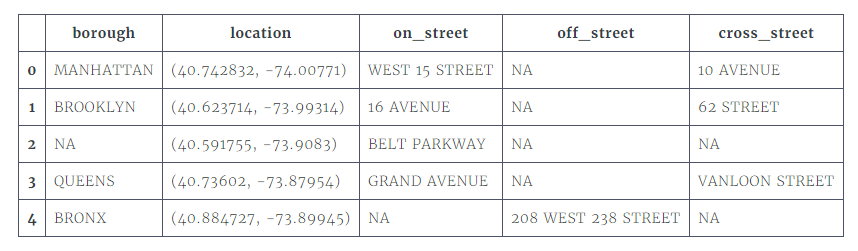

Next, let's look at counts of the NA values in each column:

`colSums(is.na(location_data))`

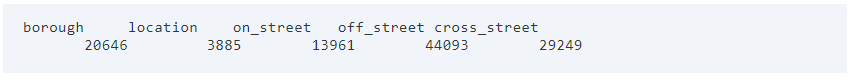

These columns have a lot of missing values! Keep in mind that all of these five columns represent the same thing — the location of the collision. We can potentially use the non-NA values to impute some of the NA values.

To see where we might be able to do this, let's look for correlations between the missing values:

`mvc_na_location <- mvc_na[location_cols]
missing_location_corr  <-  round(cor(mvc_na_location), 2)
plot_na_correlation(missing_location_corr)`

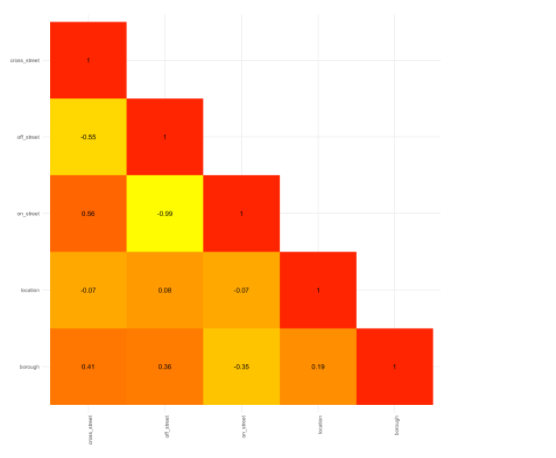

None of these columns have strong correlations except for `off_street` and `on_street`, which have a near perfect negative correlation. That means for almost every row that has a NA value in one column, the other has a non-NA value and vice-versa.

The final way we'll look at the NA values in these columns is to plot a NA matrix, but we'll sort the data first using [`arrange_all()` function](https://dplyr.tidyverse.org/reference/arrange_all.html) from dplyr package. This will gather some of the NA and non-NA values together and make patterns more obvious

`mvc_na_location <- mvc_na[location_cols] %>% arrange_all(desc)
plot_na_matrix(mvc_na_location)`


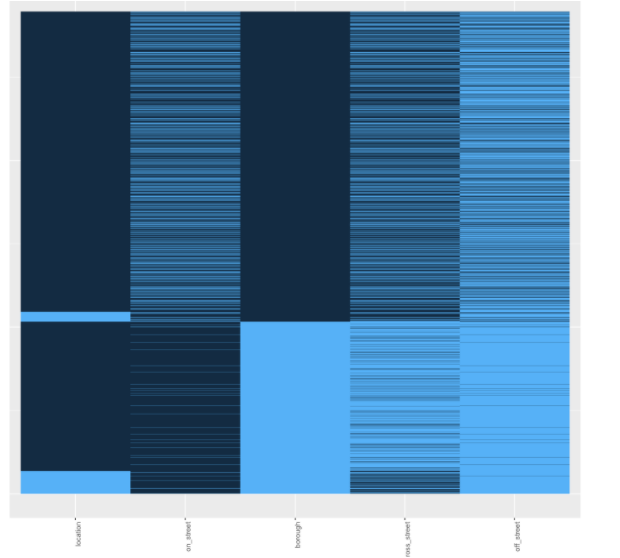

Let's make some observations about the missing values across these columns:

1. About two-thirds of rows have non-NA values for `borough`, but of the values that are missing, most have non-NA values for `location` and one or more of the street name columns.
2. Less than one-tenth of rows have missing values in the `location` column, but most of these have non-NA values in one or more of the street name columns.
3. Most rows have a non-NA value for either `on_street` or `off_street`, and some also have a value for `cross_street`.

Combined, this means that we will be able to impute a lot of the missing values by using the other columns in each row. To do this, we can use geolocation APIs that take either an address or location coordinates, and return information about that location.

Because the focus is to work with missing data, we have pre-prepared supplemental data using APIs.

We prepared the supplemental data using the [`GeoPy` package](https://geopy.readthedocs.io/en/latest/), which makes working with Geocoding APIs like the Google Maps API easier. Here's the strategy we used to prepare the supplemental data:

* For rows with `location` values but missing values in either `borough` or the street name columns, we used geocoding APIs to look up the `location` coordinates to find the missing data.
* For rows with values in the street name columns missing `borough` and/or location data, we used geocoding APIs to look up the address to find the missing data.

The supplemental data is in a CSV called `supplemental_data.csv`

`library(readr)
sup_data  <-  read_csv('supplemental_data.csv')
head(sup_data)`

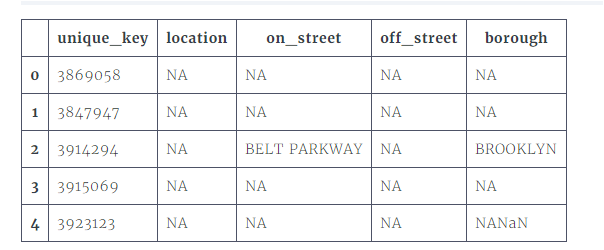

The supplemental data has five columns from our original dataset — the `unique_key` that identifies each collision, and four of the five location columns. The `cross_street` column is not included because the geocoding APIs we used don't include data on the nearest cross street to any single location.

Let's take a look at a NA matrix for the supplemental data:

`sup_data_na <- map_df(sup_data, function(x) as.numeric(is.na(x)))
plot_na_matrix(sup_data_na)`

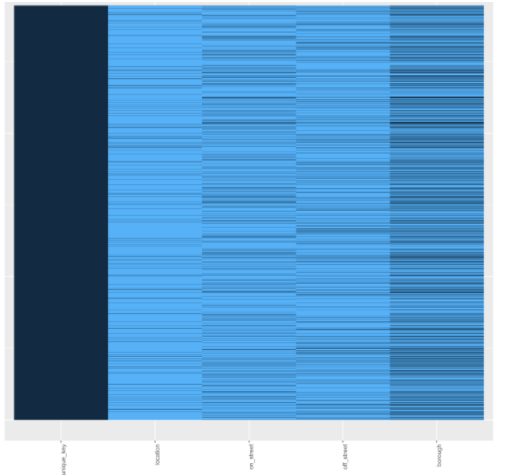

Apart from the `unique_key` column, we'll notice that there are a lot more missing values than our main dataset. This makes sense, as we didn't prepare supplemental data where the original dataset had non-NA values.

If the `unique_key` column in both the original and supplemental data has the same values in the same order, we'll be able to use `mutate()` and `if_else()` function to add our supplemental data to our original data. We can check this by using [`setequal()` function](https://dplyr.tidyverse.org/reference/setops.html):


`mvc_keys  <-  mvc['unique_key']
sup_keys  <-  sup_data['unique_key']
set_equal <- setequal(mvc_keys, sup_keys)`

`print(set_equal)
TRUE`

**Task**

* Now that we've verified the data, it's time to use it to impute missing values.

**Answer**

`library(readr)
sup_data  <-  read_csv('supplemental_data.csv')`

`location_cols  <-  c('location', 'on_street', 'off_street', 'borough')
na_before  <-  colSums(is.na(mvc[location_cols]))
for (col in location_cols ) {
    mvc[is.na(mvc[col]),col] <- sup_data[is.na(mvc[col]),col]
}`

`na_after  <-  colSums(is.na(mvc[location_cols]))`

We've imputed thousands of values to reduce the number of missing values across our dataset.


If we'd like to continue working with this data, we can:

* Drop the rows that had suspect values for `injured` and `killed` totals.
* Clean the values in the `vehicle_1` through `vehicle_5` columns by analyzing the different values and merging duplicates and near-duplicates.
* Analyze whether collisions are more likely in certain locations, at certain times, or for certain vehicle types.